In [ ]:
!pip install -q datasets transformers sentence-transformers rank-bm25 bert-score rouge-score sacrebleu


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.3 MB/s eta 0:00:00


In [1]:
import random
import json
import os

import numpy as np
import torch

from datasets import load_dataset

# Reproducibility
def set_seed(seed: int = 42):
    """
    Set all relevant random seeds (Python, NumPy, PyTorch)
    and configure cuDNN for deterministic behavior.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# **# 1. Dataset Preparation**

Load HotpotQA

In [2]:

# context = [ [title, [sent1, sent2, ...]], ... ]

raw_dataset = load_dataset("hotpot_qa", "distractor", split="validation[:200]")

print(raw_dataset)
print("\nExample keys:", raw_dataset.column_names)

example = raw_dataset[0]
print("\nExample item:")
for k, v in example.items():
    if k != "context":
        print(f"- {k}:", v)

print("\nContext structure keys:", example["context"].keys())

print("\nContext sample (first 2 entries):")
titles = example["context"]["title"]
sent_lists = example["context"]["sentences"]

for i in range(min(2, len(titles))):
    title = titles[i]
    sentences = sent_lists[i]
    print("TITLE:", title)
    print("FIRST SENTENCE:", sentences[0] if sentences else "")
    print("---")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

distractor/train-00000-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/train-00001-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/validation-00000-of-00001.par(…):   0%|          | 0.00/27.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
    num_rows: 200
})

Example keys: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context']

Example item:
- id: 5a8b57f25542995d1e6f1371
- question: Were Scott Derrickson and Ed Wood of the same nationality?
- answer: yes
- type: comparison
- level: hard
- supporting_facts: {'title': ['Scott Derrickson', 'Ed Wood'], 'sent_id': [0, 0]}

Context structure keys: dict_keys(['title', 'sentences'])

Context sample (first 2 entries):
TITLE: Ed Wood (film)
FIRST SENTENCE: Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.
---
TITLE: Scott Derrickson
FIRST SENTENCE: Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer.
---


Prepare QA Pairs

In [36]:
def prepare_qa_pairs(dataset, max_examples: int = 200):
    """
    Convert the raw HotpotQA dataset into a simple list of
    dictionaries keeping question, answer, context and supporting_facts.
    """
    qa_list = []
    for i, item in enumerate(dataset):
        if i >= max_examples:
            break
        qa_list.append(
            {
                "id": item["id"],
                "question": item["question"],
                "answer": item["answer"],
                "context": item["context"],              # context (titles + sentences)
                "supporting_facts": item["supporting_facts"],  # BUNU EKLEDİK
            }
        )
    return qa_list


In [37]:
qa_pairs = prepare_qa_pairs(raw_dataset, max_examples=200)
print(f"Prepared {len(qa_pairs)} QA pairs.")

sample = qa_pairs[0]
print("\nSample QA pair keys:", sample.keys())
print("Supporting facts:", sample["supporting_facts"])


Prepared 200 QA pairs.

Sample QA pair keys: dict_keys(['id', 'question', 'answer', 'context', 'supporting_facts'])
Supporting facts: {'title': ['Scott Derrickson', 'Ed Wood'], 'sent_id': [0, 0]}


# **2. Corpus & Prompt Preprocessing**

**Build Retrieval Corpus**

In [4]:
def build_corpus_from_hotpotqa(qa_pairs):
    """
    Convert HotpotQA context structure into a flat list of passages.
    Each passage is a string: "TITLE: X\nSENTENCES..."
    This will be the corpus for BM25/TF-IDF retrievers.
    """
    corpus = []
    passage_id = 0
    pid_to_text = {}

    for item in qa_pairs:
        titles = item["context"]["title"]
        sentences_list = item["context"]["sentences"]

        for title, sents in zip(titles, sentences_list):
            text = f"{title}. " + " ".join(sents)
            corpus.append(text)
            pid_to_text[passage_id] = text
            passage_id += 1

    return corpus, pid_to_text


corpus, pid_to_text = build_corpus_from_hotpotqa(qa_pairs)

print(f"Corpus size: {len(corpus)} passages")
print("\nExample passage:\n", corpus[0][:500])


Corpus size: 1992 passages

Example passage:
 Ed Wood (film). Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.  The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau.  Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.


Prepare Generation Examples

In [5]:
def prepare_generation_examples(qa_pairs, pid_to_text, max_contexts=3):
    """
    Prepare simple input-output pairs for generation models.
    For each question, we attach a few context passages (later replaced by retriever results).
    """
    gen_examples = []

    for item in qa_pairs:
        q = item["question"]
        gold_answer = item["answer"]


        titles = item["context"]["title"]
        sents = item["context"]["sentences"]

        ctx_chunks = []
        for title, sent_list in zip(titles[:max_contexts], sents[:max_contexts]):
            ctx_chunks.append(f"{title}. " + " ".join(sent_list))

        joined_context = "\n".join(ctx_chunks)

        gen_examples.append({
            "question": q,
            "answer": gold_answer,
            "context_text": joined_context
        })

    return gen_examples


gen_examples = prepare_generation_examples(qa_pairs, pid_to_text)
print("Prepared generation examples:", len(gen_examples))
print("\nExample generation item:")
gen_examples[0]


Prepared generation examples: 200

Example generation item:


{'question': 'Were Scott Derrickson and Ed Wood of the same nationality?',
 'answer': 'yes',
 'context_text': 'Ed Wood (film). Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.  The film concerns the period in Wood\'s life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau.  Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.\nScott Derrickson. Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer.  He lives in Los Angeles, California.  He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange."\nWoodson, Arkansas. Woodson is a census-designated place (CDP) in Pulaski County, Arkansas, in the 

**Prompt Builder**

In [6]:
def build_prompt(question, context_text):
    """
    Build a unified prompt for the generator model.
    """
    return f"question: {question}\ncontext: {context_text}\nanswer:"


In [29]:
def build_prompt(question, context_text):
    return (
        "You are a question answering system. "
        "Answer ONLY 'yes' or 'no' based on the context.\n\n"
        f"Question: {question}\n"
        f"Context: {context_text}\n"
        "Answer:"
    )


# **3. Retriever Implementation**

In [9]:
!pip install rank-bm25

In [10]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [11]:
def tokenize_for_bm25(text):
    """
    Very simple whitespace + lowercasing tokenizer for BM25.
    You can later replace with a more advanced tokenizer if desired.
    """
    return text.lower().split()


class BM25Retriever:
    """
    BM25-based sparse retriever over a given corpus of documents.
    """
    def __init__(self, corpus):
        """
        Initialize BM25 retriever with a list of documents (strings).
        """
        self.corpus = corpus
        self.tokenized_corpus = [tokenize_for_bm25(doc) for doc in corpus]
        self.bm25 = BM25Okapi(self.tokenized_corpus)

    def retrieve(self, query, top_k=5):
        """
        Retrieve top_k documents for a given query string.
        Returns: list of (index, score, text) tuples.
        """
        tokenized_query = tokenize_for_bm25(query)
        scores = self.bm25.get_scores(tokenized_query)
        # Get indices of top_k scores
        top_indices = np.argsort(scores)[::-1][:top_k]
        results = []
        for idx in top_indices:
            results.append((int(idx), float(scores[idx]), self.corpus[idx]))
        return results


bm25_retriever = BM25Retriever(corpus)
print("BM25 retriever initialized over corpus of size:", len(corpus))


BM25 retriever initialized over corpus of size: 1992


In [12]:
class TFIDFRetriever:
    """
    TF-IDF-based sparse retriever using cosine similarity.
    """
    def __init__(self, corpus):
        """
        Initialize TF-IDF retriever with a list of documents (strings).
        """
        self.corpus = corpus
        self.vectorizer = TfidfVectorizer(stop_words="english")
        self.doc_matrix = self.vectorizer.fit_transform(corpus)

    def retrieve(self, query, top_k=5):
        """
        Retrieve top_k documents for a given query string.
        Returns: list of (index, score, text) tuples.
        """
        query_vec = self.vectorizer.transform([query])
        sim_scores = cosine_similarity(query_vec, self.doc_matrix)[0]
        top_indices = np.argsort(sim_scores)[::-1][:top_k]
        results = []
        for idx in top_indices:
            results.append((int(idx), float(sim_scores[idx]), self.corpus[idx]))
        return results


tfidf_retriever = TFIDFRetriever(corpus)
print("TF-IDF retriever initialized over corpus of size:", len(corpus))


TF-IDF retriever initialized over corpus of size: 1992


**Retriever Sanity Check**

In [13]:
test_question = gen_examples[0]["question"]
print("Test question:", test_question, "\n")

print("=== BM25 Top-3 ===")
bm25_results = bm25_retriever.retrieve(test_question, top_k=3)
for rank, (idx, score, text) in enumerate(bm25_results, start=1):
    print(f"[{rank}] idx={idx}, score={score:.4f}")
    print(text[:400], "\n---\n")

print("\n=== TF-IDF Top-3 ===")
tfidf_results = tfidf_retriever.retrieve(test_question, top_k=3)
for rank, (idx, score, text) in enumerate(tfidf_results, start=1):
    print(f"[{rank}] idx={idx}, score={score:.4f}")
    print(text[:400], "\n---\n")


Test question: Were Scott Derrickson and Ed Wood of the same nationality? 

=== BM25 Top-3 ===
[1] idx=2, score=27.9802
Woodson, Arkansas. Woodson is a census-designated place (CDP) in Pulaski County, Arkansas, in the United States.  Its population was 403 at the 2010 census.  It is part of the Little Rock–North Little Rock–Conway Metropolitan Statistical Area.  Woodson and its accompanying Woodson Lake and Wood Hollow are the namesake for Ed Wood Sr., a prominent plantation owner, trader, and businessman at the tu 
---

[2] idx=0, score=24.3370
Ed Wood (film). Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.  The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau.  Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and B 
---

[3] idx=1, score=22.3242
Scott Derrickson

# **4. Generator Component**

In [14]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_NAME = "google/flan-t5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

set_seed(42)  # determinism
print("Loaded model:", MODEL_NAME)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loaded model: google/flan-t5-small


In [15]:
def generate_answer_from_context(question, context_text,
                                 max_input_length=512,
                                 max_new_tokens=16,
                                 num_beams=4):
    """
    Generate an answer given a question and context using FLAN-T5.
    """
    prompt = build_prompt(question, context_text)

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            early_stopping=True
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded.strip()


**Generator Sanity Check**

In [16]:
test_item = gen_examples[0]
print("Question:", test_item["question"])
print("Gold answer:", test_item["answer"])
print("\nContext snippet:\n", test_item["context_text"][:400], "\n")

pred_answer = generate_answer_from_context(
    question=test_item["question"],
    context_text=test_item["context_text"]
)

print("Predicted answer:", pred_answer)


Question: Were Scott Derrickson and Ed Wood of the same nationality?
Gold answer: yes

Context snippet:
 Ed Wood (film). Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.  The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau.  Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and B 

Predicted answer: no


# **5. RAG Pipeline Integration**

In [17]:
def retrieve_passages(retriever, question, top_k=3):
    """
    Wrapper that uses a given retriever instance (BM25 or TF-IDF)
    to get top_k passages (texts only).
    """
    results = retriever.retrieve(question, top_k=top_k)
    # results: list of (idx, score, text)
    passages = [text for (_, _, text) in results]
    return passages, results


**Context Assembly**

In [22]:
def combine_passages(passages, max_passages=3, max_sentences_per_passage=3):
    """
    Combine multiple passages into a single context string.
    For each passage, keep only the first few sentences to avoid
    a single long document dominating the context window.
    """
    trimmed_passages = []
    for p in passages[:max_passages]:

        sentences = p.split(". ")

        keep = ". ".join(sentences[:max_sentences_per_passage])
        trimmed_passages.append(keep)

    combined = "\n".join(trimmed_passages)
    return combined


In [26]:
def generate_rag_answer(
    question,
    retriever,
    top_k=3,
    max_passages=3,
    max_sentences_per_passage=3,
    max_input_length=512,
    max_new_tokens=16,
    num_beams=4
):
    """
    Full RAG pipeline:
    1) Retrieve top_k passages using the given retriever.
    2) Combine them into a single context (with sentence-level trimming).
    3) Generate an answer with the seq2seq model.
    Returns: (answer, passages_text, raw_results)
    """
    passages, raw_results = retrieve_passages(retriever, question, top_k=top_k)
    context_text = combine_passages(
        passages,
        max_passages=max_passages,
        max_sentences_per_passage=max_sentences_per_passage
    )

    answer = generate_answer_from_context(
        question=question,
        context_text=context_text,
        max_input_length=max_input_length,
        max_new_tokens=max_new_tokens,
        num_beams=num_beams
    )

    return answer, context_text, raw_results

**RAG Sanity Check**

In [30]:
q = gen_examples[0]["question"]
gold = gen_examples[0]["answer"]

print("QUESTION:", q)
print("GOLD ANSWER:", gold, "\n")

pred_bm25, ctx_bm25, res_bm25 = generate_rag_answer(
    question=q,
    retriever=bm25_retriever,
    top_k=3
)

print("=== RAG (BM25) PREDICTED ANSWER ===")
print(pred_bm25, "\n")

print("=== Used Context (BM25, truncated) ===")
print(ctx_bm25[:800])


QUESTION: Were Scott Derrickson and Ed Wood of the same nationality?
GOLD ANSWER: yes 

=== RAG (BM25) PREDICTED ANSWER ===
no 

=== Used Context (BM25, truncated) ===
Woodson, Arkansas. Woodson is a census-designated place (CDP) in Pulaski County, Arkansas, in the United States.  Its population was 403 at the 2010 census
Ed Wood (film). Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.  The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau
Scott Derrickson. Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer.  He lives in Los Angeles, California


In [28]:
pred_tfidf, ctx_tfidf, res_tfidf = generate_rag_answer(
    question=q,
    retriever=tfidf_retriever,
    top_k=3
)

print("\n=== RAG (TF-IDF) PREDICTED ANSWER ===")
print(pred_tfidf)



=== RAG (TF-IDF) PREDICTED ANSWER ===
no


# **6. Evaluation**

**Helper Functions (Retrieval Titles)**

In [38]:
def get_gold_titles(item):
    """
    Extract unique gold titles from HotpotQA item.
    Example: ['Ed Wood', 'Scott Derrickson']
    """
    titles = item["supporting_facts"]["title"]
    return list(set(titles))


In [39]:
def extract_title_from_passage(passage_text):
    """
    Assuming passage text begins with 'Title. sentence sentence ...'.
    """
    first_period = passage_text.find(".")
    if first_period == -1:
        return passage_text.strip()
    return passage_text[:first_period].strip()


**Precision@k and Recall@k**

In [40]:
def compute_precision_recall_at_k(retriever, qa_pairs, k=5):
    total_precision = 0
    total_recall = 0
    n = len(qa_pairs)

    for item in qa_pairs:
        q = item["question"]
        gold_titles = get_gold_titles(item)

        # retrieve top-k
        passages, raw = retrieve_passages(retriever, q, top_k=k)

        # extract predicted titles
        pred_titles = [extract_title_from_passage(text) for text in passages]

        # intersection
        correct = sum(1 for t in pred_titles if t in gold_titles)

        precision = correct / k
        recall = correct / len(gold_titles)

        total_precision += precision
        total_recall += recall

    return total_precision / n, total_recall / n


**Run Retrieval Metrics**

In [41]:
print("Computing Retrieval Metrics...")

p_bm25, r_bm25 = compute_precision_recall_at_k(bm25_retriever, qa_pairs, k=5)
p_tfidf, r_tfidf = compute_precision_recall_at_k(tfidf_retriever, qa_pairs, k=5)

print("\n=== Retrieval Metrics (k=5) ===")
print(f"BM25 Precision@5: {p_bm25:.4f}")
print(f"BM25 Recall@5:    {r_bm25:.4f}")
print()
print(f"TF-IDF Precision@5: {p_tfidf:.4f}")
print(f"TF-IDF Recall@5:    {r_tfidf:.4f}")


Computing Retrieval Metrics...

=== Retrieval Metrics (k=5) ===
BM25 Precision@5: 0.2520
BM25 Recall@5:    0.6300

TF-IDF Precision@5: 0.2630
TF-IDF Recall@5:    0.6575


In [43]:
!pip install rouge-score sacrebleu bert-score

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ae93e8dc83f7bf4ec52f701eec42482aea5378604805f4faca9aade6d917b448
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [44]:
from rouge_score import rouge_scorer
import sacrebleu
from bert_score import score as bert_score


In [45]:
def evaluate_generation_single(pred, gold):
    """
    Compute BLEU, ROUGE-L, BERTScore for a single prediction.
    """
    bleu = sacrebleu.corpus_bleu([pred], [[gold]]).score

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rougeL = scorer.score(gold, pred)['rougeL'].fmeasure

    P, R, F = bert_score([pred], [gold], lang="en", verbose=False)
    bert_f1 = float(F[0])

    return bleu, rougeL, bert_f1


In [46]:
def evaluate_generation_over_dataset(retriever, qa_pairs, k=3, max_samples=50):
    bleu_scores = []
    rouge_scores = []
    bert_scores = []

    for i, item in enumerate(qa_pairs[:max_samples]):
        q = item["question"]
        gold = item["answer"]

        pred, _, _ = generate_rag_answer(
            question=q,
            retriever=retriever,
            top_k=k,
            max_passages=3,
            max_sentences_per_passage=3
        )

        bleu, rougeL, bert_f1 = evaluate_generation_single(pred, gold)

        bleu_scores.append(bleu)
        rouge_scores.append(rougeL)
        bert_scores.append(bert_f1)

    return {
        "BLEU": float(np.mean(bleu_scores)),
        "ROUGE-L": float(np.mean(rouge_scores)),
        "BERTScore-F1": float(np.mean(bert_scores))
    }


**Print Generation Metrics**

In [47]:
print("Computing Generation Metrics over first 50 samples...")

gen_bm25 = evaluate_generation_over_dataset(bm25_retriever, qa_pairs, k=3, max_samples=50)
gen_tfidf = evaluate_generation_over_dataset(tfidf_retriever, qa_pairs, k=3, max_samples=50)

print("\n=== Generation Metrics (first 50) ===")
print("BM25 RAG:", gen_bm25)
print("TF-IDF RAG:", gen_tfidf)


Computing Generation Metrics over first 50 samples...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho


=== Generation Metrics (first 50) ===
BM25 RAG: {'BLEU': 0.0, 'ROUGE-L': 0.14, 'BERTScore-F1': 0.8807461965084076}
TF-IDF RAG: {'BLEU': 0.0, 'ROUGE-L': 0.1, 'BERTScore-F1': 0.8807471096515656}


# **7. Logging**

In [48]:
import json
from datetime import datetime

results_summary = {
    "experiment_name": "hotpotqa_rag_flan_t5_small",
    "timestamp": datetime.now().isoformat(),
    "retrieval": {
        "k": 5,
        "BM25": {
            "Precision@5": p_bm25,
            "Recall@5": r_bm25,
        },
        "TFIDF": {
            "Precision@5": p_tfidf,
            "Recall@5": r_tfidf,
        },
    },
    "generation": {
        "num_eval_samples": 50,
        "BM25_RAG": gen_bm25,
        "TFIDF_RAG": gen_tfidf,
    },
}

with open("rag_results_summary.json", "w") as f:
    json.dump(results_summary, f, indent=4)

print("Saved summary to rag_results_summary.json")
results_summary


Saved summary to rag_results_summary.json


{'experiment_name': 'hotpotqa_rag_flan_t5_small',
 'timestamp': '2025-11-25T23:17:55.564116',
 'retrieval': {'k': 5,
  'BM25': {'Precision@5': 0.252, 'Recall@5': 0.63},
  'TFIDF': {'Precision@5': 0.26299999999999985, 'Recall@5': 0.6575}},
 'generation': {'num_eval_samples': 50,
  'BM25_RAG': {'BLEU': 0.0,
   'ROUGE-L': 0.14,
   'BERTScore-F1': 0.8807461965084076},
  'TFIDF_RAG': {'BLEU': 0.0,
   'ROUGE-L': 0.1,
   'BERTScore-F1': 0.8807471096515656}}}

In [49]:
def run_and_log_examples(retriever, qa_pairs, num_examples=5, k=3):
    logs = []
    for item in qa_pairs[:num_examples]:
        q = item["question"]
        gold = item["answer"]
        pred, ctx, raw = generate_rag_answer(
            question=q,
            retriever=retriever,
            top_k=k,
            max_passages=3,
            max_sentences_per_passage=3
        )
        logs.append({
            "question": q,
            "gold_answer": gold,
            "predicted_answer": pred,
            "context": ctx,
        })
    return logs

qual_examples_bm25 = run_and_log_examples(bm25_retriever, qa_pairs, num_examples=5, k=3)

with open("rag_qualitative_examples_bm25.json", "w") as f:
    json.dump(qual_examples_bm25, f, indent=2)

qual_examples_bm25[0]


{'question': 'Were Scott Derrickson and Ed Wood of the same nationality?',
 'gold_answer': 'yes',
 'predicted_answer': 'no',
 'context': "Woodson, Arkansas. Woodson is a census-designated place (CDP) in Pulaski County, Arkansas, in the United States.  Its population was 403 at the 2010 census\nEd Wood (film). Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.  The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau\nScott Derrickson. Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer.  He lives in Los Angeles, California"}

# **8. Visualization**

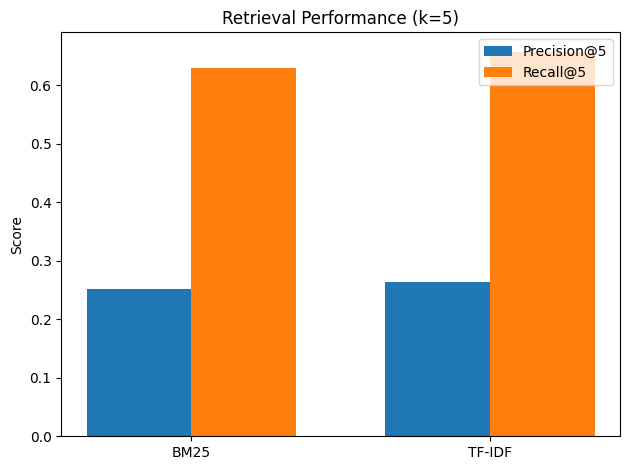

In [50]:
import matplotlib.pyplot as plt
import numpy as np

retrieval_models = ["BM25", "TF-IDF"]
precision_values = [p_bm25, p_tfidf]
recall_values = [r_bm25, r_tfidf]

x = np.arange(len(retrieval_models))
width = 0.35

plt.figure()
plt.bar(x - width/2, precision_values, width, label="Precision@5")
plt.bar(x + width/2, recall_values, width, label="Recall@5")

plt.xticks(x, retrieval_models)
plt.ylabel("Score")
plt.title("Retrieval Performance (k=5)")
plt.legend()
plt.tight_layout()
plt.show()


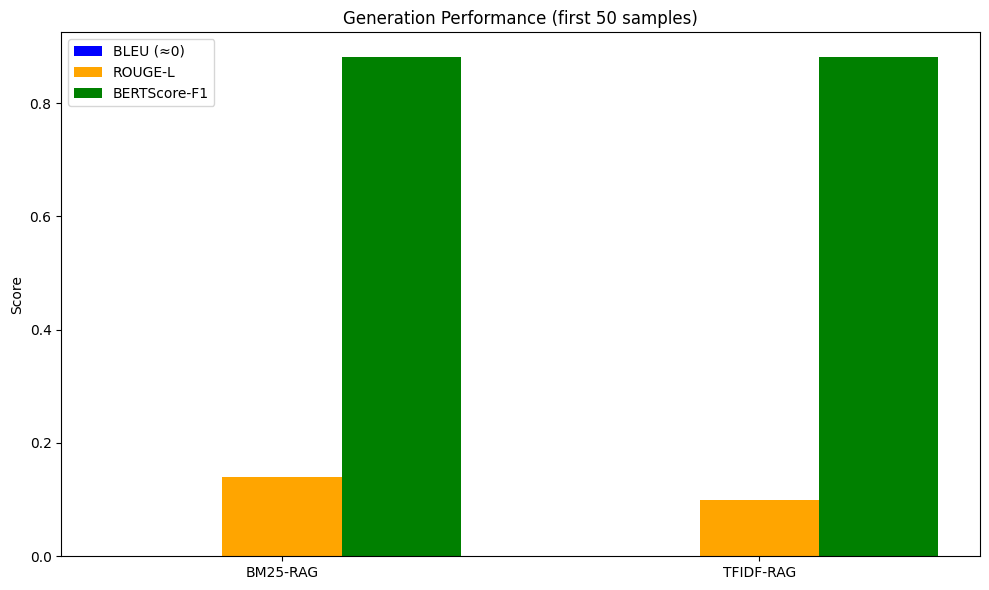

In [52]:
bleu_vals = [max(gen_bm25["BLEU"], 0.0001),
             max(gen_tfidf["BLEU"], 0.0001)]
rouge_vals = [gen_bm25["ROUGE-L"], gen_tfidf["ROUGE-L"]]
bert_vals = [gen_bm25["BERTScore-F1"], gen_tfidf["BERTScore-F1"]]

x = np.arange(len(gen_models))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, bleu_vals, width, label="BLEU (≈0)", color="blue")
plt.bar(x, rouge_vals, width, label="ROUGE-L", color="orange")
plt.bar(x + width, bert_vals, width, label="BERTScore-F1", color="green")

plt.xticks(x, gen_models)
plt.ylabel("Score")
plt.title("Generation Performance (first 50 samples)")
plt.legend()
plt.tight_layout()
plt.show()
